In [32]:
import pandas as pd
from Environments import TrainingEnv
from Environments import TestingEnv

In [33]:
from stable_baselines3.common.env_checker import check_env

In [34]:
training_data = pd.read_csv('./AMZN/Training.csv')
training_data.drop(labels=['Date'], axis=1, inplace=True)
training_data

,Close,MACD,MACD Percentage,Volume Oscillator,CV,RSI,Pct Change
0,0.075521,-0.003005,-0.372616,-0.785435,0.039340,0.133666,-0.058436
1,0.076302,-0.002888,-0.359592,-0.724346,0.036210,-0.175030,-0.036189
2,0.075000,-0.002868,-0.358814,-0.757719,0.025158,-0.164152,-0.046360
3,0.075521,-0.002777,-0.348950,-0.790495,0.024340,-0.084732,0.003468
4,0.075521,-0.002675,-0.337374,-0.751645,0.024920,0.058877,0.000000
...,...,...,...,...,...,...,...
4850,41.837002,0.883613,0.222582,0.125768,0.024597,0.412153,0.047024
4851,41.701500,0.907468,0.227740,0.060109,0.021179,0.468804,0.021958
4852,42.217999,0.957020,0.239121,0.055463,0.019349,0.473720,0.018872
4853,42.083000,0.974166,0.242481,-0.006064,0.018545,0.448564,0.015210


In [35]:
validation_data = pd.read_csv('./AMZN/Validation.csv')
validation_data.drop(labels=['Date'], axis=1, inplace=True)
validation_data

,Close,MACD,MACD Percentage,Volume Oscillator,CV,RSI,Pct Change
0,36.950500,-1.023362,-0.257741,0.366516,0.024272,-0.086110,-0.021244
1,35.953499,-1.165195,-0.295531,0.306514,0.029923,-0.136420,-0.083906
2,37.161999,-1.166635,-0.297161,0.239727,0.028807,-0.069141,-0.056503
3,37.324501,-1.141505,-0.291825,0.071750,0.028959,-0.134059,-0.032894
4,37.820000,-1.069280,-0.274033,-0.036785,0.028526,-0.070542,0.018885
...,...,...,...,...,...,...,...
1017,159.766998,-0.547009,-0.034679,-0.215389,0.010732,0.080511,0.025127
1018,158.401993,-0.409559,-0.025957,-0.153475,0.011324,0.005073,0.022146
1019,161.003998,-0.089636,-0.005672,-0.083429,0.014109,0.182408,0.039275
1020,160.176498,0.096027,0.006071,-0.121202,0.015217,0.268016,0.027411


In [36]:
testing_data = pd.read_csv('./AMZN/Testing.csv')
testing_data.drop(labels=['Date'], axis=1, inplace=True)
testing_data

,Close,MACD,MACD Percentage,Volume Oscillator,CV,RSI,Pct Change
0,155.710495,-0.096891,-0.006076,0.023335,0.021664,-0.114780,-0.022726
1,156.041504,-0.354710,-0.022280,0.012517,0.022144,-0.402939,-0.030349
2,158.294495,-0.372937,-0.023435,-0.007419,0.017719,-0.379028,0.008766
3,156.373505,-0.536209,-0.033738,-0.036577,0.014390,-0.382431,-0.010970
4,155.212494,-0.750634,-0.047311,0.026549,0.011742,-0.373813,-0.024649
...,...,...,...,...,...,...,...
1018,234.639999,4.447597,0.195408,0.002267,0.023610,0.280170,-0.003313
1019,237.679993,4.566976,0.199997,0.019791,0.015557,0.378185,0.012050
1020,237.419998,4.587722,0.200316,0.037289,0.009178,0.416929,0.008495
1021,242.059998,4.921836,0.214003,-0.007567,0.009569,0.413515,0.016418


In [37]:
episode_length = len(testing_data)

training_env = TrainingEnv(training_data, episode_length=episode_length)
check_env(training_env, warn=True)
validation_env = TestingEnv(validation_data)
check_env(validation_env, warn=True)
testing_env = TestingEnv(testing_data)
check_env(testing_env, warn=True)

In [39]:
# from stable_baselines3 import DQN
# from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
# eval_callback = EvalCallback(validation_env, eval_freq=100, callback_after_eval=stop_train_callback, verbose=1)

# model = DQN("MlpPolicy", training_env, buffer_size=5000, learning_rate=0.005, seed=6)
# model.learn(int(1e10), callback=eval_callback)

In [40]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    def __init__(self, env, eval_freq, verbose=0):
        super().__init__(verbose)
        self.env = env
        self.eval_freq = eval_freq

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            obs, info = self.env.reset()
            rewards = []
            while True:
                action, _states = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.env.step(action)
                rewards.append(reward)
                if terminated or truncated:
                    break
            self.logger.record("Mean Validation Set Reward", np.array(rewards).mean())
            self.logger.record("Cumulative Validation Set Reward", np.array(rewards).sum())
        return True


In [41]:
from stable_baselines3 import DQN

# eval_callback = EvalCallback(training_env, eval_freq=500, verbose=0)

tensorboard_callback = TensorboardCallback(validation_env, episode_length)
model = DQN("MlpPolicy", training_env, buffer_size=10000, seed=6, exploration_fraction=0.5, tensorboard_log="./tensorboard", learning_rate=0.001)
# model.learn(500*1000, callback=eval_callback)
model.learn(500*10000, callback = tensorboard_callback)

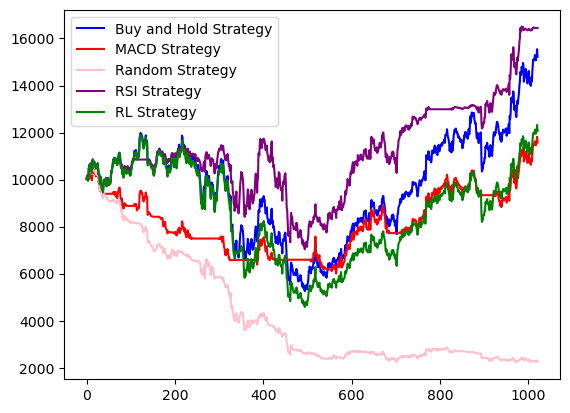

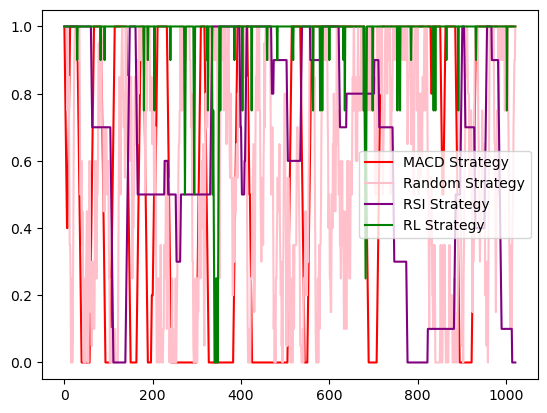

In [44]:
import matplotlib.pyplot as plt

buy_and_hold_strategy_value = []
MACD_asset_allocations = []
MACD_strategy_value = []
random_asset_allocations = []
RSI_asset_alloctions =[]
RL_strategy_value = []
RL_asset_allocations = []

obs, info = testing_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = testing_env.step(action)
    RL_strategy_value.append(info['Portfolio Value'])
    RL_asset_allocations.append(info['Asset Allocation'])
    if terminated or truncated:
        break
    

obs, info = testing_env.reset()
while True:

    # sell 10% if MACD is very low, buy 10% if MACD is very high, otherwise do nothing
    if info['MACD'] < -.3:
        action = 1
    elif info['MACD'] > 0.3:
        action = 3
    else:
        action = 2
    obs, reward, terminated, truncated, info = testing_env.step(action)
    MACD_strategy_value.append(info['Portfolio Value'])
    buy_and_hold_strategy_value.append(info['Buy and Hold Value'])
    MACD_asset_allocations.append(info['Asset Allocation'])
    if terminated or truncated:
        break

random_strategy_value = []
obs, info = testing_env.reset()
while True:

    action = testing_env.action_space.sample()
    obs, reward, terminated, truncated, info = testing_env.step(action)
    random_strategy_value.append(info['Portfolio Value'])
    random_asset_allocations.append(info['Asset Allocation'])
    if terminated or truncated:
        break

RSI_strategy_value = []
obs, info = testing_env.reset()
while True:

    # buy 10% if RSI is low, sell 10% if RSI is high 
    # RSI typically uses 30 and 70 for thresholds, which maps
    # -.4 and .4 here after taking scaling into account
    if info['RSI'] < -.4:
        action = 3
    elif info['RSI'] > 0.4:
        action = 1
    else:
        action = 2
    obs, reward, terminated, truncated, info = testing_env.step(action)
    RSI_strategy_value.append(info['Portfolio Value'])
    RSI_asset_alloctions.append(info['Asset Allocation'])
    if terminated or truncated:
        break

plt.figure()
plt.plot(buy_and_hold_strategy_value, "blue", label="Buy and Hold Strategy")
plt.plot(MACD_strategy_value, "red", label="MACD Strategy")
plt.plot(random_strategy_value, "pink", label="Random Strategy")
plt.plot(RSI_strategy_value, "purple", label="RSI Strategy")
plt.plot(RL_strategy_value, "green", label="RL Strategy")
plt.legend()

plt.figure()
plt.plot(MACD_asset_allocations, "red", label="MACD Strategy")
plt.plot(random_asset_allocations, "pink", label="Random Strategy")
plt.plot(RSI_asset_alloctions, "purple", label="RSI Strategy")
plt.plot(RL_asset_allocations, "green", label="RL Strategy")
plt.legend()
plt.show()

In [45]:
model.save("AMZN Model")

In [ ]:
# revisit features - see below
# create new branch where the dataset is split into 10 periods and alternating periods are designated for training, the rest are for validation or testing
#        change training so that training episodes consist of one of the 5 training periods to better match validation/testing periods
# fix tests for the new branch and then see if it results in better validation/testing performance
# also think about using optuna for hyperparameter tuning

In [22]:
# from stable_baselines3 import DQN
# import optuna

# max_return = 0.0

# def objective(trial):
#     global max_return
#     learning_rate = trial.suggest_float('learning rate', 0.0001, 0.01)
#     gamma = trial.suggest_float('gamma', 0.95, 0.999)
#     exploration_fraction = trial.suggest_float('exploration fraction', 0.1, 0.3)
#     total_timesteps = trial.suggest_int('total_timesteps', 250 * 50, 250 * 1000)


#     model = DQN("MlpPolicy", training_env, learning_rate=learning_rate, 
#                 buffer_size=5000, gamma=gamma, exploration_fraction=exploration_fraction)
    

#     model.learn(total_timesteps=total_timesteps)

#     obs, info = validation_env.reset()
#     while True:
#         action, _states = model.predict(obs, deterministic=True)
#         obs, reward, terminated, truncated, info = validation_env.step(action)
#         if terminated or truncated:
#             break

#     raw_return = (validation_env.portfolio_value - validation_env.budget) / validation_env.budget
#     if raw_return > max_return:
#         model.save("RL_Agent")
#         max_return = raw_return
#     del model
#     return -raw_return

    


# study = optuna.create_study()
# study.optimize(objective, n_trials = 20, show_progress_bar=True)

# print(f'Best Parameters: {study.best_params}')
# print(f'Best value: {study.best_value}')